In [29]:
import os
import pickle
import random as rn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from keras.layers.advanced_activations import LeakyReLU

pd.set_option('display.max_columns', 200)

In [30]:
!python --version

Python 3.7.10


In [31]:
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(seed) # fix random function seed
    np.random.seed(seed) # fix numpy seed
    tf.random.set_seed(seed) # fix tensorflow seed

In [32]:
def yyplot(y_true, y_pred):
    yvalues = np.concatenate([y_true.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, s=1.0)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01], color="red", linestyle = "dashed")
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('t: true value')
    plt.ylabel('y: predicted value')
    plt.title('True-Predicted Plot')
    plt.show()
    return fig

In [33]:
def metrics(y_true, y_pred):
    metrics = [r2_score(y_true=y_true, y_pred=y_pred), 
               np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), 
               mean_absolute_error(y_true=y_true, y_pred=y_pred)
              ]
    return metrics

In [34]:
# Fix Random Seed
reset_seed(1234)

In [35]:
!python --version

Python 3.7.10


Remember pickle

In [36]:
# Count File Numbers
data_dir = '/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_csv(file_dir) #pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

df_raw.describe()


file_num: 10
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_5.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_2.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_7.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_3.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_4.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_1.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_0.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_6.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_8.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv/searched_9.csv
df_raw.shape: (73

,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,Best1_Count,Best2_Count,Best_P_HPMR_MEAN,Best1_P_HPMR_MIN,Best1_P_HPMR_MAX,Best1_P_HPMR_MEAN,Best1_P_HPMR_STD,Best2_P_HPMR_MIN,Best2_P_HPMR_MAX,Best2_P_HPMR_MEAN,Best2_P_HPMR_STD,Best_P_LPMR_MEAN,Best1_P_LPMR_MIN,Best1_P_LPMR_MAX,Best1_P_LPMR_MEAN,Best1_P_LPMR_STD,Best2_P_LPMR_MIN,Best2_P_LPMR_MAX,Best2_P_LPMR_MEAN,Best2_P_LPMR_STD,Best_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_MIN,Best1_MCHE_BTM_DT_MAX,Best1_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_STD,Best2_MCHE_BTM_DT_MIN,Best2_MCHE_BTM_DT_MAX,Best2_MCHE_BTM_DT_MEAN,Best2_MCHE_BTM_DT_STD,Best_MR_C1_MEAN,Best1_MR_C1_MIN,Best1_MR_C1_MAX,Best1_MR_C1_MEAN,Best1_MR_C1_STD,Best2_MR_C1_MIN,Best2_MR_C1_MAX,Best2_MR_C1_MEAN,Best2_MR_C1_STD,Best_MR_C2_MEAN,Best1_MR_C2_MIN,Best1_MR_C2_MAX,Best1_MR_C2_MEAN,Best1_MR_C2_STD,Best2_MR_C2_MIN,Best2_MR_C2_MAX,Best2_MR_C2_MEAN,Best2_MR_C2_STD,Best_MR_C3_MEAN,Best1_MR_C3_MIN,Best1_MR_C3_MAX,Best1_MR_C3_MEAN,Best1_MR_C3_STD,Best2_MR_C3_MIN,Best2_MR_C3_MAX,Best2_MR_C3_MEAN,Best2_MR_C3_STD,Best_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_MIN,Best1_FFF_Flow_pred_MAX,Best1_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_STD,Best2_FFF_Flow_pred_MIN,Best2_FFF_Flow_pred_MAX,Best2_FFF_Flow_pred_MEAN,Best2_FFF_Flow_pred_STD,Best_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_MIN,Best1_ThermalEff_pred_MAX,Best1_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_STD,Best2_ThermalEff_pred_MIN,Best2_ThermalEff_pred_MAX,Best2_ThermalEff_pred_MEAN,Best2_ThermalEff_pred_STD,Best_SpecPower_pred_MEAN,Best1_SpecPower_pred_MIN,Best1_SpecPower_pred_MAX,Best1_SpecPower_pred_MEAN,Best1_SpecPower_pred_STD,Best2_SpecPower_pred_MIN,Best2_SpecPower_pred_MAX,Best2_SpecPower_pred_MEAN,Best2_SpecPower_pred_STD,Best_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MIN,Best1_MCHE_CB_Out_Temp_pred_MAX,Best1_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_STD,Best2_MCHE_CB_Out_Temp_pred_MIN,Best2_MCHE_CB_Out_Temp_pred_MAX,Best2_MCHE_CB_Out_Temp_pred_MEAN,Best2_MCHE_CB_Out_Temp_pred_STD
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.00000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,7.141500e+04,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000
mean,46831.414457,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06,3.161543,7.547235,51.513307,50.849372,52.241119,51.562888,0.840526,50.411133,53.088123,51.720984,1.000231,1.710449,1.702701,1.727258,1.712882,0.015565,1.700688,1.755602,1.720026,0.021729,3.016024,2.485003,3.412396,2.941760,0.579085,2.124109,3.89202,2.948036,0.662771,40.376689,40.062992,40.701574,40.381433,0.388954,39.806456,40.995911,40.409357,0.447770,40.813251,40.343549,41.356246,40.845736,0.619351,39.935582,41.766592,40.832540,0.684982,13.174517,12.854175,13.407266,13.130754,0.339359,12.589293,13.593320,13.095004,0.376718,1340.177656,1143.852188,1541.210

In [37]:
# Pretreatment of Dataset
#to be updated# 
df = df_raw.copy()
df.describe()

,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,Best1_Count,Best2_Count,Best_P_HPMR_MEAN,Best1_P_HPMR_MIN,Best1_P_HPMR_MAX,Best1_P_HPMR_MEAN,Best1_P_HPMR_STD,Best2_P_HPMR_MIN,Best2_P_HPMR_MAX,Best2_P_HPMR_MEAN,Best2_P_HPMR_STD,Best_P_LPMR_MEAN,Best1_P_LPMR_MIN,Best1_P_LPMR_MAX,Best1_P_LPMR_MEAN,Best1_P_LPMR_STD,Best2_P_LPMR_MIN,Best2_P_LPMR_MAX,Best2_P_LPMR_MEAN,Best2_P_LPMR_STD,Best_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_MIN,Best1_MCHE_BTM_DT_MAX,Best1_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_STD,Best2_MCHE_BTM_DT_MIN,Best2_MCHE_BTM_DT_MAX,Best2_MCHE_BTM_DT_MEAN,Best2_MCHE_BTM_DT_STD,Best_MR_C1_MEAN,Best1_MR_C1_MIN,Best1_MR_C1_MAX,Best1_MR_C1_MEAN,Best1_MR_C1_STD,Best2_MR_C1_MIN,Best2_MR_C1_MAX,Best2_MR_C1_MEAN,Best2_MR_C1_STD,Best_MR_C2_MEAN,Best1_MR_C2_MIN,Best1_MR_C2_MAX,Best1_MR_C2_MEAN,Best1_MR_C2_STD,Best2_MR_C2_MIN,Best2_MR_C2_MAX,Best2_MR_C2_MEAN,Best2_MR_C2_STD,Best_MR_C3_MEAN,Best1_MR_C3_MIN,Best1_MR_C3_MAX,Best1_MR_C3_MEAN,Best1_MR_C3_STD,Best2_MR_C3_MIN,Best2_MR_C3_MAX,Best2_MR_C3_MEAN,Best2_MR_C3_STD,Best_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_MIN,Best1_FFF_Flow_pred_MAX,Best1_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_STD,Best2_FFF_Flow_pred_MIN,Best2_FFF_Flow_pred_MAX,Best2_FFF_Flow_pred_MEAN,Best2_FFF_Flow_pred_STD,Best_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_MIN,Best1_ThermalEff_pred_MAX,Best1_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_STD,Best2_ThermalEff_pred_MIN,Best2_ThermalEff_pred_MAX,Best2_ThermalEff_pred_MEAN,Best2_ThermalEff_pred_STD,Best_SpecPower_pred_MEAN,Best1_SpecPower_pred_MIN,Best1_SpecPower_pred_MAX,Best1_SpecPower_pred_MEAN,Best1_SpecPower_pred_STD,Best2_SpecPower_pred_MIN,Best2_SpecPower_pred_MAX,Best2_SpecPower_pred_MEAN,Best2_SpecPower_pred_STD,Best_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MIN,Best1_MCHE_CB_Out_Temp_pred_MAX,Best1_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_STD,Best2_MCHE_CB_Out_Temp_pred_MIN,Best2_MCHE_CB_Out_Temp_pred_MAX,Best2_MCHE_CB_Out_Temp_pred_MEAN,Best2_MCHE_CB_Out_Temp_pred_STD
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.00000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,7.141500e+04,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000
mean,46831.414457,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06,3.161543,7.547235,51.513307,50.849372,52.241119,51.562888,0.840526,50.411133,53.088123,51.720984,1.000231,1.710449,1.702701,1.727258,1.712882,0.015565,1.700688,1.755602,1.720026,0.021729,3.016024,2.485003,3.412396,2.941760,0.579085,2.124109,3.89202,2.948036,0.662771,40.376689,40.062992,40.701574,40.381433,0.388954,39.806456,40.995911,40.409357,0.447770,40.813251,40.343549,41.356246,40.845736,0.619351,39.935582,41.766592,40.832540,0.684982,13.174517,12.854175,13.407266,13.130754,0.339359,12.589293,13.593320,13.095004,0.376718,1340.177656,1143.852188,1541.210

34


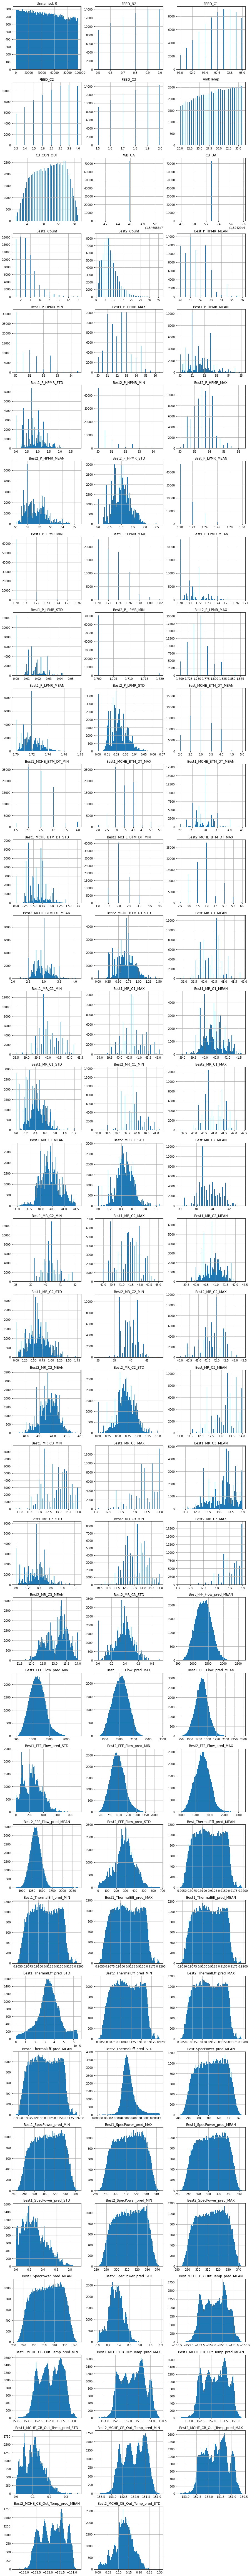

In [38]:
# Visuallization of each tag
#to be updated# 
import math

num_row = math.ceil(len(df.columns) / 3)
print(num_row)

plt.figure(figsize=(15, 5 * num_row))
i=0

for tag in df.columns:
    i += 1
     
    plt.subplot(num_row, 3, i)
    x1=df[tag]
    plt.hist(x=x1, bins=100)
    plt.grid()
    plt.title(label=tag)
    
plt.show()

In [39]:
# Scaler
sc_x = StandardScaler()
sc_y = StandardScaler()

In [40]:
#To be updated according to the Specification#

# explanatory variable - given
list_u = [
    'FEED_N2',
    'FEED_C1',
    'FEED_C2',
    'FEED_C3',
#     'FEED_iC4',
#     'FEED_nC4',
#     'FEED_C5+',
    'AmbTemp',
    'C3_CON_OUT',
#     'MCHE_IN_T',
    'WB_UA',
    'CB_UA'
]

# explanatory variable - search
list_v = [
#     'P_HPMR',
#     'P_LPMR',
#     'MCHE_BTM_DT',
# #     'MR_N2',
#     'MR_C1',
#     'MR_C2',
#     'MR_C3'
]

list_x = list_u + list_v

In [41]:
df_x = df.loc[:, list_x]
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04
mean,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06
std,0.166510,0.277559,0.218537,0.166638,4.685239,4.841059,3.758844e-06,2.385366e-06
min,0.500000,92.000000,3.300000,1.500000,20.000000,41.200000,1.546086e+07,1.894295e+06
25%,0.600000,92.400000,3.500000,1.600000,24.500000,47.700000,1.546086e+07,1.894295e+06
50%,0.800000,92.600000,3.700000,1.800000,29.000000,52.200000,1.546086e+07,1.894295e+06
75%,0.900000,92.800000,3.900000,1.900000,32.500000,55.700000,1.546086e+07,1.894295e+06
max,1.000000,93.000000,4.000000,2.000000,36.000000,61.200000,1.546086e+07,1.894295e+06


In [42]:
list_y = [
    'Best1_P_HPMR_MEAN',
    'Best1_P_LPMR_MEAN',
    'Best1_MCHE_BTM_DT_MEAN',
    'Best1_MR_C1_MEAN',
    'Best1_MR_C2_MEAN',
    'Best1_MR_C3_MEAN',
    'Best1_FFF_Flow_pred_MEAN',
    'Best1_ThermalEff_pred_MEAN',
    'Best1_SpecPower_pred_MEAN',
    'Best1_MCHE_CB_Out_Temp_pred_MEAN'
]

In [43]:
df_y = df.loc[:, list_y]
df_y.describe()

,Best1_P_HPMR_MEAN,Best1_P_LPMR_MEAN,Best1_MCHE_BTM_DT_MEAN,Best1_MR_C1_MEAN,Best1_MR_C2_MEAN,Best1_MR_C3_MEAN,Best1_FFF_Flow_pred_MEAN,Best1_ThermalEff_pred_MEAN,Best1_SpecPower_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MEAN
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000
mean,51.562888,1.712882,2.941760,40.381433,40.845736,13.130754,1337.373249,0.911605,312.998338,-151.818404
std,0.975700,0.012053,0.379027,0.448085,0.460374,0.533833,182.046594,0.003212,13.211405,0.500232
min,50.000000,1.700000,2.000000,38.900000,39.175000,11.266667,721.486938,0.904464,282.240295,-153.337372
25%,50.875000,1.700000,2.666667,40.033333,40.500000,12.725000,1217.936157,0.908937,302.060005,-152.226330
50%,51.500000,1.711429,3.000000,40.375000,40.800000,13.266667,1336.922302,0.911531,313.371796,-151.793144
75%,52.250000,1.720000,3.125000,40.675000,41.160000,13.500000,1449.313568,0.914347,324.076027,-151.409794
max,55.083333,1.766667,4.500000,41.650000,42.350000,14.000000,2469.686035,0.919793,342.967773,-150.679932


In [44]:
x = df_x.values
y = df_y.values

In [45]:
x_scaled = sc_x.fit_transform(x)
y_scaled = sc_y.fit_transform(y)

In [46]:
# Save Scaler File
from pickle import dump
dump(sc_x, open('/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params_sc_x.pkl', 'wb'))
dump(sc_y, open('/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params_sc_y.pkl', 'wb'))

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=0,shuffle=False)

In [48]:
# Define Model
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Dense(units=25, input_dim=input_dim, activation='tanh'))
model.add(Dense(units=35, activation='tanh'))
model.add(Dense(units=55, activation='tanh'))
model.add(Dense(units=35, activation='tanh'))
model.add(Dense(units=25, activation='tanh'))
model.add(Dense(units=output_dim))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25)                225       
_________________________________________________________________
dense_7 (Dense)              (None, 35)                910       
_________________________________________________________________
dense_8 (Dense)              (None, 55)                1980      
_________________________________________________________________
dense_9 (Dense)              (None, 35)                1960      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                900       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                260       
Total params: 6,235
Trainable params: 6,235
Non-trainable params: 0
____________________________________________________

In [49]:
model_path_out = '/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params.h5'
mc = ModelCheckpoint(filepath=model_path_out, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [50]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=2000, verbose=1, callbacks=[mc], validation_data=(x_test, y_test))

Streaming output truncated to the last 5000 lines.
Epoch 751/2000
516/516 [==============================] - 1s 3ms/step - loss: 0.0619 - val_loss: 0.0629

Epoch 00751: val_loss did not improve from 0.05971
Epoch 752/2000
516/516 [==============================] - 1s 3ms/step - loss: 0.0605 - val_loss: 0.0640

Epoch 00752: val_loss did not improve from 0.05971
Epoch 753/2000
516/516 [==============================] - 1s 3ms/step - loss: 0.0611 - val_loss: 0.0628

Epoch 00753: val_loss did not improve from 0.05971
Epoch 754/2000
516/516 [==============================] - 1s 3ms/step - loss: 0.0614 - val_loss: 0.0637

Epoch 00754: val_loss did not improve from 0.05971
Epoch 755/2000
516/516 [==============================] - 2s 3ms/step - loss: 0.0609 - val_loss: 0.0755

Epoch 00755: val_loss did not improve from 0.05971
Epoch 756/2000
516/516 [==============================] - 1s 3ms/step - loss: 0.0728 - val_loss: 0.0622

Epoch 00756: val_loss did not improve from 0.05971
Epoch 757/200

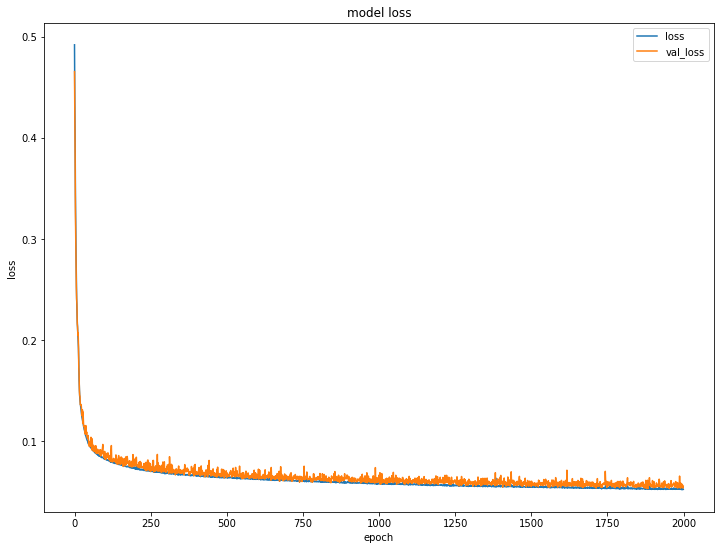

In [51]:
# Show Learning Curve
fig = plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],"-",label="loss",)
plt.plot(history.history['val_loss'],"-",label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [52]:
model_best = load_model(model_path_out)
y_pred = model_best.predict(x_test)
y_pred = y_pred.reshape(-1,y.shape[1])
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)

# 予測精度の評価
mtrc = metrics(y_true=y_test_inv, y_pred=y_pred_inv)
print("r2       : %.4f" % mtrc[0])
print("rmse     : %.4f" % mtrc[1])
print("rmse/avg.: %.6f" % (mtrc[1] / abs(y_test_inv.mean())))
print("mae      : %.4f" % mtrc[2])
print("mae/avg. : %.6f" % (mtrc[2] / abs(y_test_inv.mean())))

r2       : 0.9473
rmse     : 19.3124
rmse/avg.: 0.117210
mae      : 4.6264
mae/avg. : 0.028079


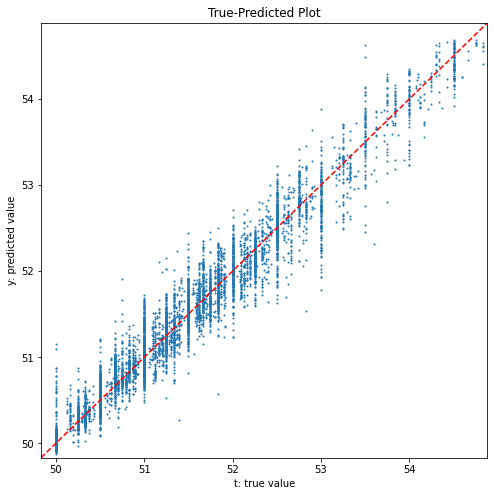

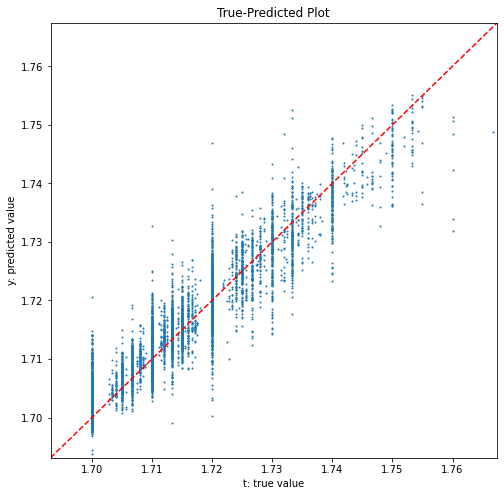

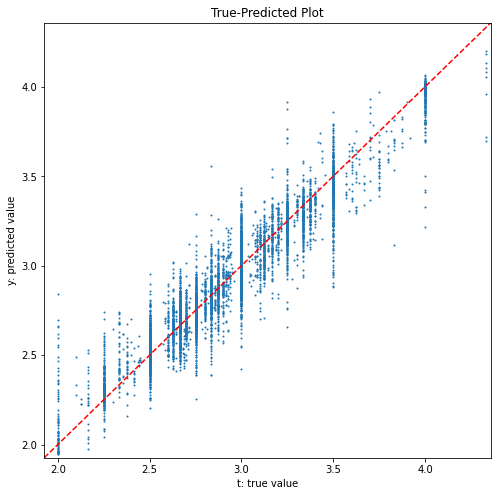

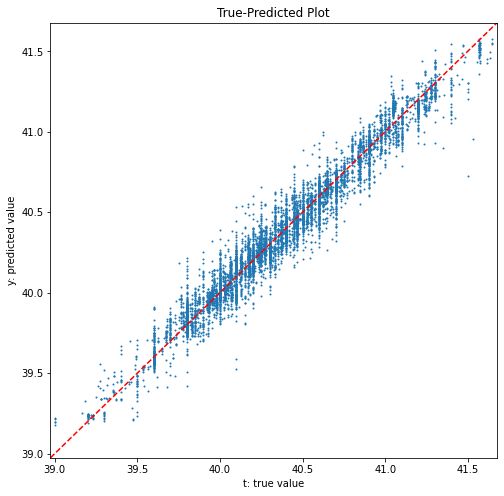

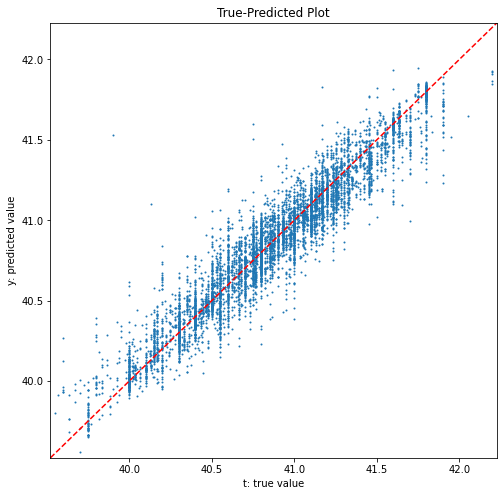

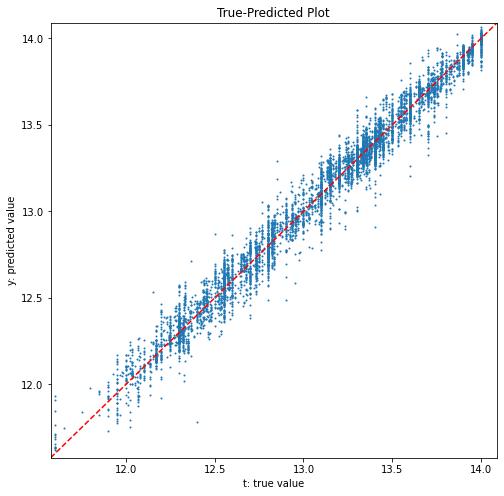

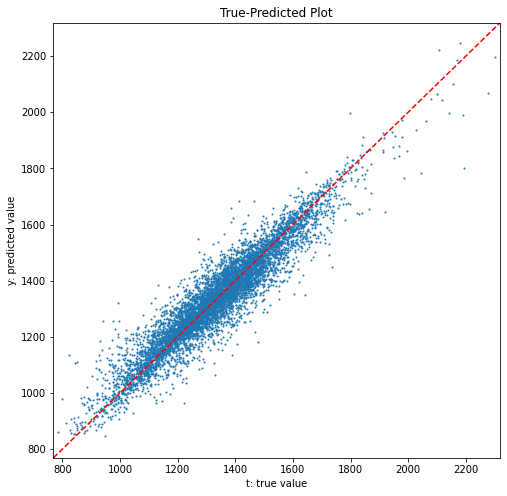

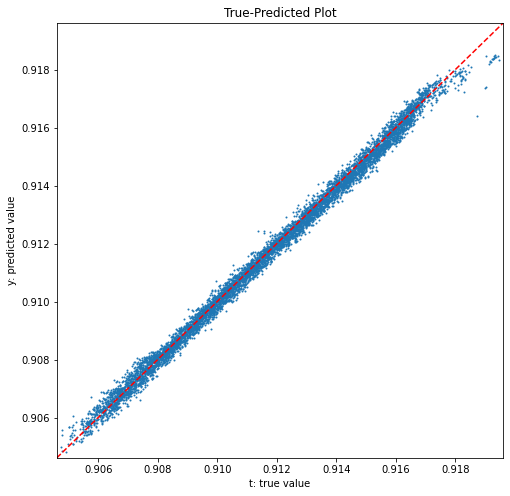

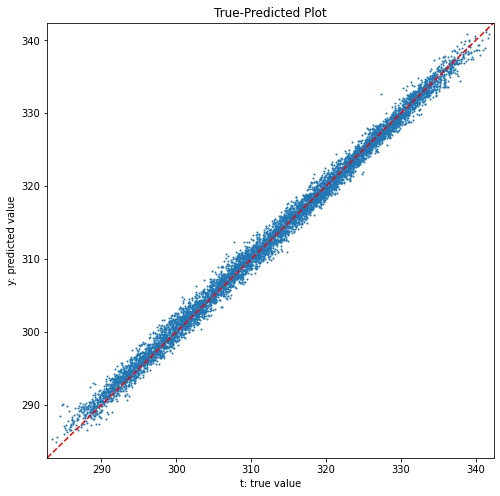

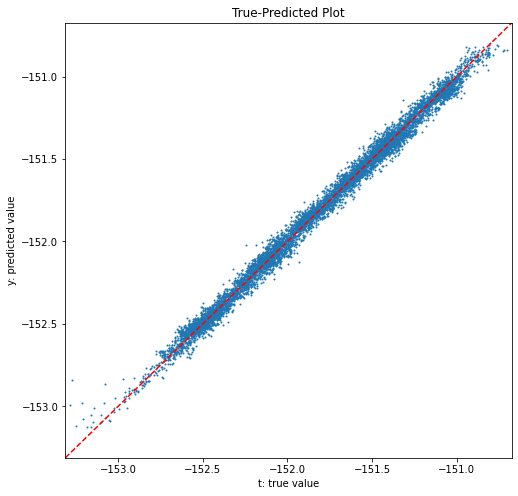

In [53]:
# テストデータの正解値と予測値のプロット
for i in range (0,y.shape[1]):
    fig = yyplot(y_true = y_test_inv[:,i], y_pred = y_pred_inv[:,i])

# # テストデータの正解値と予測値のプロット
# fig = yyplot(y_true=y_test_inv, y_pred=y_pred_inv)

For CGH usage

In [54]:
# Scaler Information for Javascript
# label
print("Scaler Information")

list_sc_x = []
for i in df_x.describe():
    list_sc_x.append(i)
print("\n    // Input_Values", list_sc_x)
print("    X:{")

# mean
list_sc_x = []
for i in df_x.mean():
    list_sc_x.append(round(i,6))
print("        mean:", list_sc_x, ",")

# std
list_sc_x = []
for i in df_x.std():
    list_sc_x.append(round(i,6))
print("        std:", list_sc_x, ",")

# max
list_sc_x = []
for i in df_x.max():
    list_sc_x.append(round(i,6))
print("        max:", list_sc_x, ",")

# min
list_sc_x = []
for i in df_x.min():
    list_sc_x.append(round(i,6))
print("        min:", list_sc_x, ",")

print("    },")


# label
list_sc_y = []
for i in df_y.describe():
    list_sc_y.append(i)
print("\n    // Output_Values", list_sc_y)
print("    Y:{")

# mean
list_sc_y = []
for i in df_y.mean():
    list_sc_y.append(round(i,6))
print("        mean:", list_sc_y, ",")

# std
list_sc_y = []
for i in df_y.std():
    list_sc_y.append(round(i,6))
print("        std:", list_sc_y, ",")
print("    },")

Scaler Information

    // Input_Values ['FEED_N2', 'FEED_C1', 'FEED_C2', 'FEED_C3', 'AmbTemp', 'C3_CON_OUT', 'WB_UA', 'CB_UA']
    X:{
        mean: [0.773096, 92.597326, 3.694651, 1.775014, 28.532628, 51.763529, 15460864.579707, 1894295.279957] ,
        std: [0.16651, 0.277559, 0.218537, 0.166638, 4.685239, 4.841059, 4e-06, 2e-06] ,
        max: [1.0, 93.0, 4.0, 2.0, 36.0, 61.2, 15460864.579703, 1894295.279959] ,
        min: [0.5, 92.0, 3.3, 1.5, 20.0, 41.2, 15460864.579703, 1894295.279959] ,
    },

    // Output_Values ['Best1_P_HPMR_MEAN', 'Best1_P_LPMR_MEAN', 'Best1_MCHE_BTM_DT_MEAN', 'Best1_MR_C1_MEAN', 'Best1_MR_C2_MEAN', 'Best1_MR_C3_MEAN', 'Best1_FFF_Flow_pred_MEAN', 'Best1_ThermalEff_pred_MEAN', 'Best1_SpecPower_pred_MEAN', 'Best1_MCHE_CB_Out_Temp_pred_MEAN']
    Y:{
        mean: [51.562888, 1.712882, 2.94176, 40.381433, 40.845736, 13.130754, 1337.373249, 0.911605, 312.998338, -151.818404] ,
        std: [0.9757, 0.012053, 0.379027, 0.448085, 0.460374, 0.533833, 182.04659